In [1]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from astropy import units as un

from few.utils.utility import get_fundamental_frequencies
from few.trajectory.flux import RunSchwarzEccFluxInspiral

from lisaconstants import ASTRONOMICAL_YEAR, GM_SUN, c, PARSEC_METER, NEWTON_CONSTANT, SUN_MASS

from ldc.common import tools
from ldc.lisa.orbits import Orbits
from ldc.lisa.projection import ProjectedStrain
from ldc.waveform.waveform import HpHc
from ldc.common.series.timeseries import FrequencySeries
from ldc.common.series import TDI
from ldc.lisa.noise import get_noise_model
from ldc.common.tools import compute_tdi_snr


Bad key "text.kerning_factor" on line 4 in
/home/philippe/.local/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# load EMRI catalog provided by SB.
nparams = 19
datat = np.zeros((1, 19))
nsourcest = 0
dir_cats = "data/raw_catalog_emri/"

for f in glob(dir_cats+"*"):
    dataf = np.loadtxt(f, skiprows=1)
    print(f"File: {f}\nNumber of sources in file={dataf.shape[0]}")
    datat = np.append(datat, dataf, axis=0)
    nsourcest += dataf.shape[0]

datat = datat[1:, :] # remove first line of zeros
print(f"Total number of sources= {datat.shape[0]}")

File: /home/philippe/Desktop/M1model/EMRICAT101_MBH10_SIGMA2_NPL1010_CUSP1_JON2_SPIN1_EuNK0_SNR_cut.dat
Number of sources in file=292
File: /home/philippe/Desktop/M1model/EMRICAT103_MBH10_SIGMA2_NPL1010_CUSP1_JON2_SPIN1_EuNK0_SNR_cut.dat
Number of sources in file=297
File: /home/philippe/Desktop/M1model/EMRICAT107_MBH10_SIGMA2_NPL1010_CUSP1_JON2_SPIN1_EuNK0_SNR_cut.dat
Number of sources in file=310
File: /home/philippe/Desktop/M1model/EMRICAT104_MBH10_SIGMA2_NPL1010_CUSP1_JON2_SPIN1_EuNK0_SNR_cut.dat
Number of sources in file=304
File: /home/philippe/Desktop/M1model/EMRICAT106_MBH10_SIGMA2_NPL1010_CUSP1_JON2_SPIN1_EuNK0_SNR_cut.dat
Number of sources in file=273
File: /home/philippe/Desktop/M1model/EMRICAT108_MBH10_SIGMA2_NPL1010_CUSP1_JON2_SPIN1_EuNK0_SNR_cut.dat
Number of sources in file=306
File: /home/philippe/Desktop/M1model/EMRICAT110_MBH10_SIGMA2_NPL1010_CUSP1_JON2_SPIN1_EuNK0_SNR_cut.dat
Number of sources in file=303
File: /home/philippe/Desktop/M1model/EMRICAT109_MBH10_SIGMA2_N

In [3]:
# Filter concateneted catalog by selecting only sources with valid eccentricity @ plunge, time @ plunge and  
# maximum frequency for HM.
parameters = ['tPlunge', 'logmu', 'logM', 'ePlunge', 'nuPlunge', 'gamPlunge', 'phiPlunge', 'costhetaSky',
              'phiSky', 'cosLambda', 'alpPlunge', 'SMBHspin', 'costhetaSpin', 'phiSpin', 'Zeta',
              'SMBHQuad', 'SNRI', 'SNRII', 'SNR_tot'] 

data_tuple = [tuple(d) for d in datat]
dtype = [(p, 'f4') for p in parameters]
data = np.array(data_tuple, dtype=dtype)

mask_ = np.zeros(data.shape, dtype=np.bool_)

for k, param in enumerate(data):
    select_source = True
    
    epl = param['ePlunge']
    tpl = param['tPlunge']
    
    # check if eccentricity is in [0., 0.25] at plunge
    if not ((0 < epl) & (epl < 0.25)):
        select_source = False
        
    # check if time is in [1.1, 1.9] yrs = [34713964.73990016, 59960484.55073663] s at plunge
    if not ((1.1 * ASTRONOMICAL_YEAR < tpl) & (tpl < 1.9 * ASTRONOMICAL_YEAR)):
        select_source = False

    if select_source:
        mask_[k] = 1
    
data_filtered = data[mask_]
nsources_filtered = data_filtered.shape[0]
print(f"Number of source parameters after filtering on time and ecc at plunge= {nsources_filtered}")

Number of source parameters after filtering on time and ecc at plunge= 1433


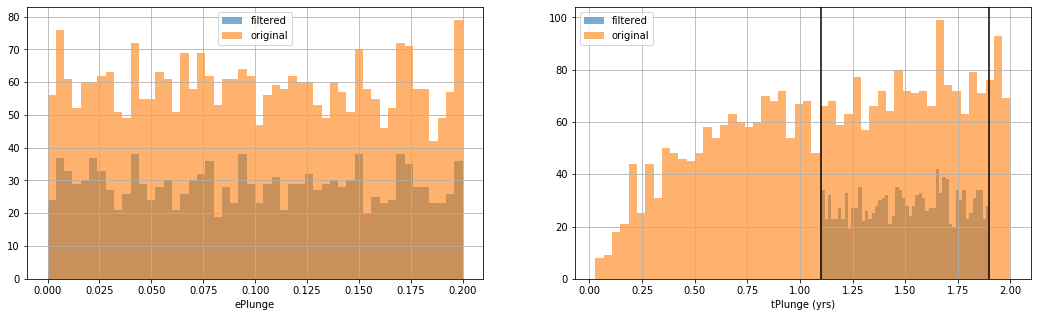

In [4]:
# plot eccentricity and times at plunge
bins = 50
tplunge_min, tplunge_max = 34713964.73990016, 59960484.55073663 # s

fig, ax = plt.subplots(1, 2, figsize=(18, 5))

name_fig = 'ePlunge'
ax[0].hist(data_filtered[name_fig], bins=bins, alpha=0.6, label='filtered')
ax[0].hist(data[name_fig], bins=bins, alpha=0.6, label='original')
ax[0].set_xlabel(name_fig)
ax[0].legend()
ax[0].grid()

name_fig = 'tPlunge'
ax[1].hist(data_filtered[name_fig] / ASTRONOMICAL_YEAR, bins=bins, alpha=0.6, label='filtered')
ax[1].hist(data[name_fig] / ASTRONOMICAL_YEAR, bins=bins, alpha=0.6, label='original')
ax[1].axvline(tplunge_min / ASTRONOMICAL_YEAR, color='k')
ax[1].axvline(tplunge_max / ASTRONOMICAL_YEAR, color='k')
ax[1].set_xlabel(name_fig+" (yrs)")
ax[1].legend()
ax[1].grid()

plt.show()

Apparently, it is needless to filter on eccentricity as all values are already below 0.2

In [5]:
dt = 10 # s
t_max = 2 * ASTRONOMICAL_YEAR # 2 * ASTRONOMICAL_YEAR # s
approximant = "FSEF"
eps = 1e-5

names = [
    'MassMBHB',
    'MassSOBHB',
    'InitialSemiLatusRect',
    'InitialEccentricity',
    'InitialPolarAngleL',
    'InitialAzimuthalAngleL',
    'InitialPhasePhiR',
    'InitialPhase',
    'Distance',
    'Cadence',
    'ObservationDuration',
    'eps',
    'EclipticLatitude',
    'EclipticLongitude'
]

In [6]:
# Backward integration to infer (e_0, p_0) from (e_plunge, p_plunge) [grid]

# compute effective catalog from original one above.
dtype_pp = [(n, 'f4') for n in names]
cat = np.zeros((nsources_filtered,), dtype=dtype_pp)

traj = RunSchwarzEccFluxInspiral()

cat['MassMBHB'] = np.exp(data_filtered['logM']) * (c**3 / GM_SUN)
cat['MassSOBHB'] = np.exp(data_filtered['logmu']) * (c**3 / GM_SUN)

M = cat['MassMBHB']
mu = cat['MassSOBHB']
t_plunge = data_filtered['tPlunge']
e_plunge = data_filtered['ePlunge']

N = 20
TOL = 0.1
TOL_et = 0.1
accepted_indices = []

year = 265.25*24*3600

for k, (M_, mu_, e_p, t_p) in enumerate(zip(M, mu, e_plunge, t_plunge)):

    choice_e0, choice_p0 = None, None
    choice_ef, choice_pf = None, None
    c_t, c_e = None, None
    current_mindist = 99
    grid_e = np.linspace(0.01, 0.7, N)
    grid_p = np.linspace(10.0, 16.0, N)
    
    for e0 in grid_e:
        for p0 in grid_p:
            t, p, e, Phi_phi, Phi_r, flux = traj(M_, mu_, p0, e0, T=t_p/year, dt=dt)
    
            idx_time = np.abs(t - t_p).argmin()
            final_e = e[idx_time]
            final_p = p[idx_time]
                
            if np.abs(final_e - e_p) < current_mindist:
                c_t = (t_p*(1-TOL_et) < t[-1]) and (t[-1] < t_p*(1)) and (t[-1]/year < 2) and ((t[idx_time]/year < 2))
                c_e = (e_p*(1-TOL_et) < e[-1]) and (e[-1] < e_p*(1+TOL_et))
                if c_e and c_t:
                    current_mindist = np.abs(final_e - e_p)
                    choice_e0 = e0
                    choice_p0 = p0
                    choice_ef = final_e
                    choice_pf = final_p
                    t_ = t
                    idx_time_ = idx_time
                    
                    cat['InitialEccentricity'][k] = choice_e0
                    cat['InitialSemiLatusRect'][k] = choice_p0
                    cat['InitialPhasePhiR'][k] = Phi_r[0]
                    cat['InitialPhase'][k] = Phi_phi[0]
                    
                else:
                    c_e, c_t = None, None
                    
    if (c_e is None) or (c_t is None):
        print(f"Not fulfilling conditions for params {k}. Skipping...")
        continue
        
    if (choice_e0 is None) or (choice_p0 is None):
        print(f"Could not find e0 or p0 for params {k}. Skipping...")
        continue
        
    ### CHECK
    t2, p2, e2, Phi_phi, Phi_r, flux = traj(M_, mu_, choice_p0, choice_e0, T=t_p/year, dt=dt)
    assert np.allclose(t_, t2, atol=1e-3)
    print(choice_ef, e2[idx_time_])
    print(choice_pf, p2[idx_time_])
        
    accepted_indices.append(k)

    print(k)
    print(f"Condition e= {c_e} | condition t= {c_t}")
    print(f"Plunge time= {t_p/year}yr | Plunge time traj= {t[idx_time]/year}yr")
    print(f"Initial: e0= {choice_e0} | p0= {choice_p0}")
    print(f"Plunge target: ep= {e_p}")
    print(f"Plunge traj: ep= {choice_ef} | pp= {choice_pf}\n")    

0.19657158471676742 0.19657158471676742
6.493143177074176 6.493143177074176
0
Condition e= True | condition t= True
Plunge time= 1.9024208468600552yr | Plunge time traj= 1.963121772143085yr
Initial: e0= 0.37315789473684213 | p0= 11.578947368421053
Plunge target: ep= 0.19741229712963104
Plunge traj: ep= 0.19657158471676742 | pp= 6.493143177074176

Not fulfilling conditions for params 1. Skipping...
Not fulfilling conditions for params 2. Skipping...
Not fulfilling conditions for params 3. Skipping...
Not fulfilling conditions for params 4. Skipping...
Not fulfilling conditions for params 5. Skipping...
Not fulfilling conditions for params 6. Skipping...
Not fulfilling conditions for params 7. Skipping...
Not fulfilling conditions for params 8. Skipping...
Not fulfilling conditions for params 9. Skipping...
Not fulfilling conditions for params 10. Skipping...
Not fulfilling conditions for params 11. Skipping...
Not fulfilling conditions for params 12. Skipping...
Not fulfilling condition

Not fulfilling conditions for params 83. Skipping...
Not fulfilling conditions for params 84. Skipping...
Not fulfilling conditions for params 85. Skipping...
Not fulfilling conditions for params 86. Skipping...
Not fulfilling conditions for params 87. Skipping...
Not fulfilling conditions for params 88. Skipping...
Not fulfilling conditions for params 89. Skipping...
Not fulfilling conditions for params 90. Skipping...
Not fulfilling conditions for params 91. Skipping...
Not fulfilling conditions for params 92. Skipping...
0.12893834781583027 0.12893834781583027
6.357876703660782 6.357876703660782
93
Condition e= True | condition t= True
Plunge time= 1.5786354592103886yr | Plunge time traj= 1.6355176918607568yr
Initial: e0= 0.2642105263157895 | p0= 12.210526315789473
Plunge target: ep= 0.1357342004776001
Plunge traj: ep= 0.12893834781583027 | pp= 6.357876703660782

Not fulfilling conditions for params 94. Skipping...
Not fulfilling conditions for params 95. Skipping...
Not fulfilling 

Not fulfilling conditions for params 170. Skipping...
0.06733569228035756 0.06733569228035756
6.234671393391197 6.234671393391197
171
Condition e= True | condition t= True
Plunge time= 1.9154407093238384yr | Plunge time traj= 1.9080123980016366yr
Initial: e0= 0.15526315789473685 | p0= 13.473684210526315
Plunge target: ep= 0.07210911065340042
Plunge traj: ep= 0.06733569228035756 | pp= 6.234671393391197

Not fulfilling conditions for params 172. Skipping...
Not fulfilling conditions for params 173. Skipping...
Not fulfilling conditions for params 174. Skipping...
0.1965712159102501 0.1965712159102501
6.493142440132474 6.493142440132474
175
Condition e= True | condition t= True
Plunge time= 1.870471951687786yr | Plunge time traj= 1.857015116155759yr
Initial: e0= 0.37315789473684213 | p0= 11.578947368421053
Plunge target: ep= 0.19019052386283875
Plunge traj: ep= 0.1965712159102501 | pp= 6.493142440132474

Not fulfilling conditions for params 176. Skipping...
Not fulfilling conditions for p

Not fulfilling conditions for params 251. Skipping...
Not fulfilling conditions for params 252. Skipping...
Not fulfilling conditions for params 253. Skipping...
Not fulfilling conditions for params 254. Skipping...
Not fulfilling conditions for params 255. Skipping...
Not fulfilling conditions for params 256. Skipping...
Not fulfilling conditions for params 257. Skipping...
Not fulfilling conditions for params 258. Skipping...
Not fulfilling conditions for params 259. Skipping...
Not fulfilling conditions for params 260. Skipping...
Not fulfilling conditions for params 261. Skipping...
Not fulfilling conditions for params 262. Skipping...
Not fulfilling conditions for params 263. Skipping...
Not fulfilling conditions for params 264. Skipping...
Not fulfilling conditions for params 265. Skipping...
Not fulfilling conditions for params 266. Skipping...
Not fulfilling conditions for params 267. Skipping...
Not fulfilling conditions for params 268. Skipping...
Not fulfilling conditions fo

Not fulfilling conditions for params 354. Skipping...
Not fulfilling conditions for params 355. Skipping...
Not fulfilling conditions for params 356. Skipping...
Not fulfilling conditions for params 357. Skipping...
Not fulfilling conditions for params 358. Skipping...
0.07493294593998479 0.07493294593998479
6.249865898969013 6.249865898969013
359
Condition e= True | condition t= True
Plunge time= 1.722422592243516yr | Plunge time traj= 1.7398612479536308yr
Initial: e0= 0.15526315789473685 | p0= 12.526315789473685
Plunge target: ep= 0.07858511060476303
Plunge traj: ep= 0.07493294593998479 | pp= 6.249865898969013

Not fulfilling conditions for params 360. Skipping...
Not fulfilling conditions for params 361. Skipping...
Not fulfilling conditions for params 362. Skipping...
Not fulfilling conditions for params 363. Skipping...
Not fulfilling conditions for params 364. Skipping...
Not fulfilling conditions for params 365. Skipping...
Not fulfilling conditions for params 366. Skipping...
0

Not fulfilling conditions for params 456. Skipping...
Not fulfilling conditions for params 457. Skipping...
Not fulfilling conditions for params 458. Skipping...
0.03160368524930675 0.03160368524930675
6.163207379000333 6.163207379000333
459
Condition e= True | condition t= True
Plunge time= 1.687504799804517yr | Plunge time traj= 1.6903361958349237yr
Initial: e0= 0.08263157894736842 | p0= 15.052631578947368
Plunge target: ep= 0.03297174349427223
Plunge traj: ep= 0.03160368524930675 | pp= 6.163207379000333

Not fulfilling conditions for params 460. Skipping...
Not fulfilling conditions for params 461. Skipping...
Not fulfilling conditions for params 462. Skipping...
Not fulfilling conditions for params 463. Skipping...
Not fulfilling conditions for params 464. Skipping...
Not fulfilling conditions for params 465. Skipping...
Not fulfilling conditions for params 466. Skipping...
Not fulfilling conditions for params 467. Skipping...
Not fulfilling conditions for params 468. Skipping...
N

Not fulfilling conditions for params 538. Skipping...
Not fulfilling conditions for params 539. Skipping...
Not fulfilling conditions for params 540. Skipping...
0.07493259869496886 0.07493259869496886
6.2498652051096455 6.2498652051096455
541
Condition e= True | condition t= True
Plunge time= 1.9112908856075679yr | Plunge time traj= 1.9011814854039246yr
Initial: e0= 0.15526315789473685 | p0= 12.526315789473685
Plunge target: ep= 0.07145078480243683
Plunge traj: ep= 0.07493259869496886 | pp= 6.2498652051096455

Not fulfilling conditions for params 542. Skipping...
Not fulfilling conditions for params 543. Skipping...
Not fulfilling conditions for params 544. Skipping...
0.10247341937149886 0.10247341937149886
6.304946846711582 6.304946846711582
545
Condition e= True | condition t= True
Plunge time= 2.016008482563619yr | Plunge time traj= 1.9692615375327243yr
Initial: e0= 0.19157894736842107 | p0= 11.578947368421053
Plunge target: ep= 0.09688983112573624
Plunge traj: ep= 0.1024734193714

Not fulfilling conditions for params 609. Skipping...
Not fulfilling conditions for params 610. Skipping...
Not fulfilling conditions for params 611. Skipping...
Not fulfilling conditions for params 612. Skipping...
Not fulfilling conditions for params 613. Skipping...
0.12107859025698148 0.12107859025698148
6.342157190219866 6.342157190219866
614
Condition e= True | condition t= True
Plunge time= 1.656585506335742yr | Plunge time traj= 1.661659738121976yr
Initial: e0= 0.37315789473684213 | p0= 16.0
Plunge target: ep= 0.12311428040266037
Plunge traj: ep= 0.12107859025698148 | pp= 6.342157190219866

Not fulfilling conditions for params 615. Skipping...
Not fulfilling conditions for params 616. Skipping...
Not fulfilling conditions for params 617. Skipping...
0.15820605863125964 0.15820605863125964
6.416412125965928 6.416412125965928
618
Condition e= True | condition t= True
Plunge time= 1.8554344259433797yr | Plunge time traj= 1.8148298825781968yr
Initial: e0= 0.3005263157894737 | p0= 1

Not fulfilling conditions for params 693. Skipping...
Not fulfilling conditions for params 694. Skipping...
Not fulfilling conditions for params 695. Skipping...
Not fulfilling conditions for params 696. Skipping...
Not fulfilling conditions for params 697. Skipping...
0.18493700006546868 0.18493700006546868
6.469874009675133 6.469874009675133
698
Condition e= True | condition t= True
Plunge time= 1.8449814989353162yr | Plunge time traj= 1.8399197245791514yr
Initial: e0= 0.4094736842105263 | p0= 12.842105263157894
Plunge target: ep= 0.18523702025413513
Plunge traj: ep= 0.18493700006546868 | pp= 6.469874009675133

Not fulfilling conditions for params 699. Skipping...
Not fulfilling conditions for params 700. Skipping...
Not fulfilling conditions for params 701. Skipping...
Not fulfilling conditions for params 702. Skipping...
0.15820484094149784 0.15820484094149784
6.416409691499439 6.416409691499439
703
Condition e= True | condition t= True
Plunge time= 1.7400211191398751yr | Plunge ti

Not fulfilling conditions for params 753. Skipping...
Not fulfilling conditions for params 754. Skipping...
Not fulfilling conditions for params 755. Skipping...
Not fulfilling conditions for params 756. Skipping...
Not fulfilling conditions for params 757. Skipping...
Not fulfilling conditions for params 758. Skipping...
Not fulfilling conditions for params 759. Skipping...
Not fulfilling conditions for params 760. Skipping...
Not fulfilling conditions for params 761. Skipping...
Not fulfilling conditions for params 762. Skipping...
Not fulfilling conditions for params 763. Skipping...
Not fulfilling conditions for params 764. Skipping...
Not fulfilling conditions for params 765. Skipping...
Not fulfilling conditions for params 766. Skipping...
Not fulfilling conditions for params 767. Skipping...
Not fulfilling conditions for params 768. Skipping...
Not fulfilling conditions for params 769. Skipping...
Not fulfilling conditions for params 770. Skipping...
Not fulfilling conditions fo

Not fulfilling conditions for params 856. Skipping...
Not fulfilling conditions for params 857. Skipping...
0.1682255860947608 0.1682255860947608
6.436451181582405 6.436451181582405
858
Condition e= True | condition t= True
Plunge time= 1.9061603309247042yr | Plunge time traj= 1.9341253140364438yr
Initial: e0= 0.37315789473684213 | p0= 12.842105263157894
Plunge target: ep= 0.16662384569644928
Plunge traj: ep= 0.1682255860947608 | pp= 6.436451181582405

Not fulfilling conditions for params 859. Skipping...
Not fulfilling conditions for params 860. Skipping...
Not fulfilling conditions for params 861. Skipping...
Not fulfilling conditions for params 862. Skipping...
0.1920315721661097 0.1920315721661097
6.484063151868255 6.484063151868255
863
Condition e= True | condition t= True
Plunge time= 1.5665139456138513yr | Plunge time traj= 1.5332787706488689yr
Initial: e0= 0.4094736842105263 | p0= 12.526315789473685
Plunge target: ep= 0.18532465398311615
Plunge traj: ep= 0.1920315721661097 | pp

Not fulfilling conditions for params 930. Skipping...
Not fulfilling conditions for params 931. Skipping...
Not fulfilling conditions for params 932. Skipping...
Not fulfilling conditions for params 933. Skipping...
0.10942645435013265 0.10942645435013265
6.318852918033755 6.318852918033755
934
Condition e= True | condition t= True
Plunge time= 1.9624660522916886yr | Plunge time traj= 1.9558933025580127yr
Initial: e0= 0.3368421052631579 | p0= 16.0
Plunge target: ep= 0.10665497928857803
Plunge traj: ep= 0.10942645435013265 | pp= 6.318852918033755

Not fulfilling conditions for params 935. Skipping...
Not fulfilling conditions for params 936. Skipping...
Not fulfilling conditions for params 937. Skipping...
Not fulfilling conditions for params 938. Skipping...
Not fulfilling conditions for params 939. Skipping...
Not fulfilling conditions for params 940. Skipping...
Not fulfilling conditions for params 941. Skipping...
Not fulfilling conditions for params 942. Skipping...
Not fulfilling 

Not fulfilling conditions for params 1023. Skipping...
Not fulfilling conditions for params 1024. Skipping...
Not fulfilling conditions for params 1025. Skipping...
0.06733506713402108 0.06733506713402108
6.234670144088813 6.234670144088813
1026
Condition e= True | condition t= True
Plunge time= 1.690451530701295yr | Plunge time traj= 1.7082852690959818yr
Initial: e0= 0.15526315789473685 | p0= 13.473684210526315
Plunge target: ep= 0.06384194642305374
Plunge traj: ep= 0.06733506713402108 | pp= 6.234670144088813

Not fulfilling conditions for params 1027. Skipping...
Not fulfilling conditions for params 1028. Skipping...
Not fulfilling conditions for params 1029. Skipping...
Not fulfilling conditions for params 1030. Skipping...
Not fulfilling conditions for params 1031. Skipping...
Not fulfilling conditions for params 1032. Skipping...
Not fulfilling conditions for params 1033. Skipping...
Not fulfilling conditions for params 1034. Skipping...
0.1723150251864964 0.1723150251864964
6.444

Not fulfilling conditions for params 1112. Skipping...
Not fulfilling conditions for params 1113. Skipping...
Not fulfilling conditions for params 1114. Skipping...
Not fulfilling conditions for params 1115. Skipping...
Not fulfilling conditions for params 1116. Skipping...
Not fulfilling conditions for params 1117. Skipping...
Not fulfilling conditions for params 1118. Skipping...
Not fulfilling conditions for params 1119. Skipping...
Not fulfilling conditions for params 1120. Skipping...
0.06733544374864533 0.06733544374864533
6.234670894475765 6.234670894475765
1121
Condition e= True | condition t= True
Plunge time= 1.6842343002757705yr | Plunge time traj= 1.6775264455568568yr
Initial: e0= 0.15526315789473685 | p0= 13.473684210526315
Plunge target: ep= 0.06920779496431351
Plunge traj: ep= 0.06733544374864533 | pp= 6.234670894475765

0.15820395061502765 0.15820395061502765
6.416407910027105 6.416407910027105
1122
Condition e= True | condition t= True
Plunge time= 1.6859016650958216yr

0.04453821500893609 0.04453821500893609
6.1890764371658635 6.1890764371658635
1213
Condition e= True | condition t= True
Plunge time= 1.7445233357768701yr | Plunge time traj= 1.7462705324371837yr
Initial: e0= 0.11894736842105262 | p0= 15.052631578947368
Plunge target: ep= 0.045250054448843
Plunge traj: ep= 0.04453821500893609 | pp= 6.1890764371658635

0.13691652147813282 0.13691652147813282
6.373833050303901 6.373833050303901
1214
Condition e= True | condition t= True
Plunge time= 2.0821878381680454yr | Plunge time traj= 2.083814957635665yr
Initial: e0= 0.4094736842105263 | p0= 15.68421052631579
Plunge target: ep= 0.1354883313179016
Plunge traj: ep= 0.13691652147813282 | pp= 6.373833050303901

0.14560700411657782 0.14560700411657782
6.391214016470491 6.391214016470491
1215
Condition e= True | condition t= True
Plunge time= 1.8367589974517402yr | Plunge time traj= 1.833669914860013yr
Initial: e0= 0.4094736842105263 | p0= 15.052631578947368
Plunge target: ep= 0.15131250023841858
Plunge t

0.06508207255012373 0.06508207255012373
6.230164153751522 6.230164153751522
1318
Condition e= True | condition t= True
Plunge time= 1.928470520473348yr | Plunge time traj= 1.931526061739491yr
Initial: e0= 0.15526315789473685 | p0= 13.789473684210526
Plunge target: ep= 0.0676710307598114
Plunge traj: ep= 0.06508207255012373 | pp= 6.230164153751522

Not fulfilling conditions for params 1319. Skipping...
Not fulfilling conditions for params 1320. Skipping...
Not fulfilling conditions for params 1321. Skipping...
Not fulfilling conditions for params 1322. Skipping...
Not fulfilling conditions for params 1323. Skipping...
0.06972106996191829 0.06972106996191829
6.239442148800659 6.239442148800659
1324
Condition e= True | condition t= True
Plunge time= 1.582520857332356yr | Plunge time traj= 1.5650549171318138yr
Initial: e0= 0.15526315789473685 | p0= 13.157894736842106
Plunge target: ep= 0.06956477463245392
Plunge traj: ep= 0.06972106996191829 | pp= 6.239442148800659

Not fulfilling conditio

Not fulfilling conditions for params 1385. Skipping...
Not fulfilling conditions for params 1386. Skipping...
Not fulfilling conditions for params 1387. Skipping...
Not fulfilling conditions for params 1388. Skipping...
Not fulfilling conditions for params 1389. Skipping...
Not fulfilling conditions for params 1390. Skipping...
0.1365114273738736 0.1365114273738736
6.373022863639069 6.373022863639069
1391
Condition e= True | condition t= True
Plunge time= 1.5847909030614027yr | Plunge time traj= 1.5560054001973285yr
Initial: e0= 0.3368421052631579 | p0= 13.789473684210526
Plunge target: ep= 0.13758230209350586
Plunge traj: ep= 0.1365114273738736 | pp= 6.373022863639069

Not fulfilling conditions for params 1392. Skipping...
Not fulfilling conditions for params 1393. Skipping...
0.08752258792525067 0.08752258792525067
6.275045183576923 6.275045183576923
1394
Condition e= True | condition t= True
Plunge time= 1.9783061053513458yr | Plunge time traj= 1.9796538297074064yr
Initial: e0= 0.22

In [8]:
# complete catalog and filter
# from ldc.common import constants
# MTsun = constants.Nature.SUN_GM/constants.Nature.VELOCITYOFLIGHT_CONSTANT_VACUUM**3
# cat['Distance'] = (cat['MassSOBHB'] * MTsun * c) / (data_filtered['Zeta']) / (1e6*PARSEC_METER) # Mpc

cat['InitialPolarAngleL'] = np.arccos(data_filtered['costhetaSky'])
cat['InitialAzimuthalAngleL'] = data_filtered['phiSky']
cat['Distance'] = ((cat['MassSOBHB'] * GM_SUN) / (data_filtered['Zeta'] * c**2))  / (1e6*PARSEC_METER) # Mpc
cat['Cadence'] = np.array(nsources_filtered * [dt])
cat['ObservationDuration'] = np.array(nsources_filtered * [t_max])
cat['eps'] = np.array(nsources_filtered * [eps])
cat['EclipticLatitude'] = np.random.uniform(low=0.0, high=np.pi, size=nsources_filtered) # compute it differently
cat['EclipticLongitude'] = np.arccos(data_filtered['cosLambda'])

catf = cat[accepted_indices]
nsources_filtered = catf.shape[0]
print(f"Number of source parameters before filtering on integration= {cat.shape[0]}")
print(f"Number of source parameters after filtering on integration= {catf.shape[0]}")

Number of source parameters before filtering on integration= 1433
Number of source parameters after filtering on integration= 202


In [ ]:
# save filtered cat
# np.save('catf_v0705.npy', catf)
# catf = np.load('catf_v0705.npy')
# catf = np.load('catf_test.npy')

The cell below is commented as it takes time to run and keep saying that all lines in the catalog above are conserved when checking for sampling. Taking dt=10s seems to be a good choice.

In [ ]:
# Filter previous catalog with check on max frequency
# check if highest frequency within higher modes remains lower than Nyquist frequency
# mask_ = np.zeros(cat.size, dtype=np.bool_)

# for k, line in enumerate(cat):    
#     # URL: https://bhptoolkit.org/FastEMRIWaveforms/html/user/util.html?highlight=get_fundamental_frequencies#few.utils.utility.get_fundamental_frequencies
#     a = 0.0
#     e0 = line['InitialEccentricity']
#     p0 = line['InitialSemiLatusRect']
    
#     # compute inlination then x
#     # eclLat = line['EclipticLatitude']
#     # eclLon = line['EclipticLongitude']
#     # theL = line['InitialPolarAngleL']
#     # phiL = line['InitialAzimuthalAngleL']
#     # _, incl = tools.aziPolAngleL2PsiIncl(eclLat, eclLon, theL, phiL)
#     # x = np.float64(np.cos(incl))
#     x = np.float64(np.pi/2) # $I$ is the angle between the orbital angular momentum vector and the equatorial plane.
    
#     # evolve trajectory
#     M = line['MassMBHB']
#     mu = line['MassSOBHB']
#     traj = RunSchwarzEccFluxInspiral()
#     t, p, e, Phi_phi, Phi_r, flux = traj(M, mu, p0, e0)
    
#     final_e = e[-1]
#     final_p = p[-1]
    
#     # compute final omegas
#     OmegaPhi, OmegaTheta, OmegaR = get_fundamental_frequencies(a, final_p, final_e, x)
#     f_phi = OmegaPhi / (2*np.pi)
#     f_theta = OmegaTheta / (2*np.pi)
#     f_R = OmegaR / (2*np.pi)
    
#     # check
#     f_nyquist = 1 / (2 * line['Cadence'])
#     print(k, f_nyquist, [f_phi, f_theta, f_R])
    
#     flag_phi = f_phi < f_nyquist
#     flag_theta = f_theta < f_nyquist
#     flag_R = f_R < f_nyquist
    
#     if flag_phi and flag_theta and flag_R:
#         mask_[k] = 1
    
# catf = cat[mask_]
# print(f"Number of source parameters after filtering on frequencies= {catf.size}")

In [ ]:
# compute SNR with TDI
# tdi2 = False
# snr_window = [45, 50]
# nsources_filteredf = catf.shape[0]

# lisa_orbits = Orbits.type(
#     dict({"nominal_arm_length":2.5e9*un.m,
#           "initial_rotation":0*un.rad,
#           "initial_position":0*un.rad,
#           "orbit_type":"analytic"})
# )
# P = ProjectedStrain(lisa_orbits)
# hphc = HpHc.type("demo", "EMRI", approximant)
# trange = np.arange(0, t_max, dt)

# # for n, param in enumerate(cat):
# draw_snr = 0    
# while not (snr_window[0] < draw_snr < snr_window[1]):
    
#     idx_src = np.random.randint(nsources_filteredf)
#     base_params = catf[idx_src]
        
#     # Extract infos
#     print("===============================")
#     print(f"processing {idx_src+1}th waveform...")
#     dict_params = dict(zip(names, base_params))
    
#     # random jitter
#     base_params['MassMBHB'] *= 1 + np.random.normal(0, 0.05)
#     base_params['MassSOBHB'] *= 1 + np.random.normal(0, 0.05)
#     base_params['Distance'] *= 1 + np.random.normal(0, 0.05)
    
#     print(f"waveform parameters: {dict_params}")

#     hphc.set_param(dict_params)
#     P.arm_response(0, t_max, dt, [hphc])

#     X = FrequencySeries(P.compute_tdi_x(trange, tdi2=tdi2), df=1/t_max)
#     Y = FrequencySeries(P.compute_tdi_y(trange, tdi2=tdi2), df=1/t_max)
#     Z = FrequencySeries(P.compute_tdi_z(trange, tdi2=tdi2), df=1/t_max)
#     XYZ_slow = TDI([X, Y, Z], ["X", "Y", "Z"])

#     # compute SNR LDC from TDI XYZ
#     fmin, fmax = X.f[0], X.f[-1]
#     N_ldc = get_noise_model("SciRDv1", X.f)
#     psd = N_ldc.psd(X.f, option='X', tdi2=tdi2)
#     dict_snr = compute_tdi_snr(XYZ_slow, N_ldc, AET=False, full_output=True)
#     snr = np.sqrt(dict_snr["tot2"])
#     print(f"> SNR[LDC]={snr}")
    
#     draw_snr = snr

# print(f"\n>>> Selected set of params={dict_params}")

The code below has been placed in a script then ran in parallel on a cluster to get the SNR estimate for each set of parameters in the above filtered catalog with ~200 sources.

In [ ]:
# compute SNR with TDI [SB way: AET]
from astropy import units as un
from ldc.common.series.tdi import XYZ2AET
from ldc.common.tools.snr import compute_tdi_snr_xyz, compute_tdi_snr_aet

idx_src = 33
tdi2 = False
nsources_filteredf = catf.shape[0]

lisa_orbits = Orbits.type(
    dict({"nominal_arm_length":2.5e9*un.m,
          "initial_rotation":0*un.rad,
          "initial_position":0*un.rad,
          "orbit_type":"analytic"})
)
P = ProjectedStrain(lisa_orbits)
hphc = HpHc.type("demo", "EMRI", approximant)
trange = np.arange(0, t_max, dt)



base_params = catf[idx_src]
base_params['ObservationDuration'] = t_max

# Extract infos
print("===============================")
print(f"processing {idx_src+1}th waveform...")
# dict_params = dict(zip(names, base_params))
dict_params = {'MassMBHB': 652906.56, 'MassSOBHB': 33.117004, 'InitialSemiLatusRect': 14.421053, 'InitialEccentricity': 0.51842105, 'InitialPolarAngleL': 2.4444764, 'InitialAzimuthalAngleL': 1.7642292, 'InitialPhasePhiR': 0.0, 'InitialPhase': 0.0, 'Distance': 18819.004, 'Cadence': 10.0, 'ObservationDuration': 63116300.0, 'eps': 1e-05, 'EclipticLatitude': 1.2986726, 'EclipticLongitude': 1.1272, 'SNR': 49.41171071068907}

print(f"waveform parameters: {dict_params}")

hphc.set_param(dict_params)
P.arm_response(0, t_max, dt, [hphc])

X = FrequencySeries(P.compute_tdi_x(trange, tdi2=tdi2), df=1/t_max)
Y = FrequencySeries(P.compute_tdi_y(trange, tdi2=tdi2), df=1/t_max)
Z = FrequencySeries(P.compute_tdi_z(trange, tdi2=tdi2), df=1/t_max)
XYZ_slow = TDI(
    dict(
        zip(["X", "Y", "Z"], [X, Y, Z])
    )
)

# convert to AET
AET_slow = XYZ2AET(XYZ_slow)
A = AET_slow["A"]

# compute SNR LDC from TDI XYZ
fmin, fmax = X.f[0], X.f[-1]
N_ldc = get_noise_model("SciRDv1", X.f)
# psd = N_ldc.psd(X.f, option='X', tdi2=tdi2)
dict_snr = compute_tdi_snr(XYZ_slow, N_ldc, AET=False, full_output=True)
# dict_snr = compute_tdi_snr_xyz(XYZ_slow, N_ldc, XYZ_slow, fmin, fmax, tdi2=tdi2, full_output=True)
snr = np.sqrt(dict_snr["tot2"])
print(f"> SNR[LDC XYZ]={snr}")

# compute SNR LDC from TDI AET
fmin, fmax = A.f[0], A.f[-1]
N_ldc = get_noise_model("SciRDv1", A.f)
# psd = N_ldc.psd(A.f, option='A', tdi2=tdi2)
dict_snr = compute_tdi_snr(AET_slow, N_ldc, AET=True, full_output=True)
# dict_snr = compute_tdi_snr_aet(AET_slow, N_ldc, AET_slow, fmin, fmax, tdi2=tdi2, full_output=True)
snr = np.sqrt(dict_snr["tot2"])
print(f"> SNR[LDC AET]={snr}")